# Recoloring CNN

In [1]:
#Imports

from pathlib import Path
import torch, os
import matplotlib.pyplot as plt
import torchvision.transforms as t
from torch import nn, optim

!pip install kornia

In [2]:
# Data preprocessing
train_path = Path.cwd() / "train"
test_path = Path.cwd() / "test"

from turtle import color
from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
from kornia.color import rgb_to_lab, lab_to_rgb
#from skimage.color import lab2rgb, rgb2lab, rgb2gray
import numpy as np
#from natsort import natsorted

class Data(Dataset):
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
        # List all images in folder and count them
        self.all_imgs = os.listdir(main_dir)
    
    def __len__(self):
        # Return the previously computed number of images
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])

        # Use PIL for image loading
        img = Image.open(img_loc).convert("RGB")
        
        # Apply transformations
        image = self.transform(img)

        # Turn RBG -> LAB
        img_lab = rgb_to_lab(image)
        # Extract l and ab channels into sepparate tensors
        img_ab = img_lab[1:3,:,:]
        img_l = img_lab[0:1,:,:]

        return img_l, img_ab

from torchvision.transforms import Compose
transform = Compose([t.ToTensor(), t.CenterCrop(256)])

example_dataset = Data(train_path, transform)
l, ab = example_dataset[300]
print(len(example_dataset))


3455


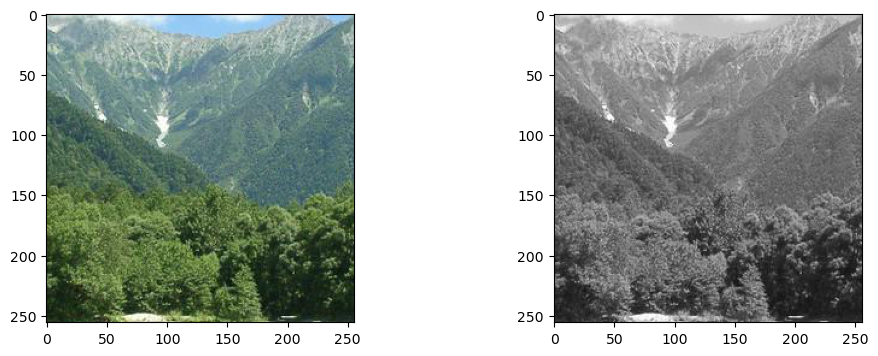

In [3]:
def plot_comb(l_input, ab_input, img_size = 256):
    '''Show rgb image from grayscale and ab channels'''
    # Genrate ab for grayscale plot
    bw_ab = torch.zeros((2,img_size,img_size))

    # Combine channels
    color_image = torch.cat((l_input, ab_input), 0)
    bw_image = torch.cat((l_input, bw_ab), 0)
    
    # Lab -> RBG for plotting
    color_img = lab_to_rgb(color_image)
    bw_img = lab_to_rgb(bw_image)
    
    fig, axes = plt.subplots(ncols=2, figsize=(12,4))
    #fig, axes = plt.subplots(1, 2, figsize=(20,10))
    img_data = color_img.permute(1, 2, 0)
    axes[0].imshow(img_data, cmap='gray')
    img_data = bw_img.permute(1, 2, 0)
    axes[1].imshow(img_data, cmap='gray')
    
def display_image(axis, image_tensor):
    """Display a tensor as an image
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0)
    axis.imshow(image_data, cmap='gray')
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.

def display_comp(g_img, img):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    display_image(axes[0], g_img)
    display_image(axes[1], img)
    plt.show()

# Example usage
some_random_index = 300
l, ab = example_dataset[some_random_index]
plot_comb(l, ab)
# display_comp(lab_to_rgb(g_img), lab_to_rgb(c_img))

In [4]:
from torch.utils.data import DataLoader

batch_size = 16
train_dataset = Data(train_path, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Data(test_path, transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [17]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.models as models

## CNN MODULE
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 1, stride = 2), 
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1, stride = 2), 
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1, stride = 2), 
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.layer_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=2, kernel_size=3, padding = 1)
        )
        
        self.layer_5 = nn.Sequential(
            nn.Upsample(scale_factor = (8,8))
        )
        
    def forward(self, input_batch):
        x = self.layer_1(input_batch)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        return x

model = CNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=0.0)

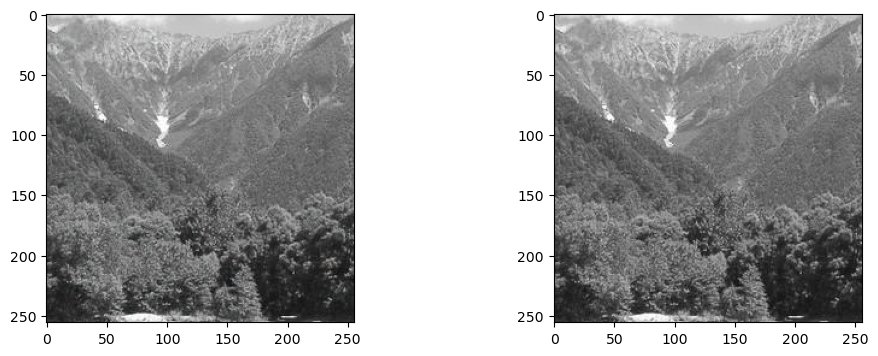

In [18]:
# Test a forward pass though the network
l, ab = example_dataset[some_random_index]
l_batch = torch.unsqueeze(l, 0)
ab_res = model.forward(l_batch).detach()
ab_res = torch.squeeze(ab_res, dim = 0)
plot_comb(l, ab_res)

In [19]:
def plot_metrics(fig, ax, ns, train_losses):

    # Plot losses
    ax.clear()
    ax.plot(ns, train_losses)
    #ax[0].plot(ns, val_losses)
    ax.set_title('Loss')
    ax.legend(['Train','Validation'])
    ax.set_xlabel('Number of trained batches')
    ax.grid()
    
    fig.canvas.draw()

<IPython.core.display.Javascript object>


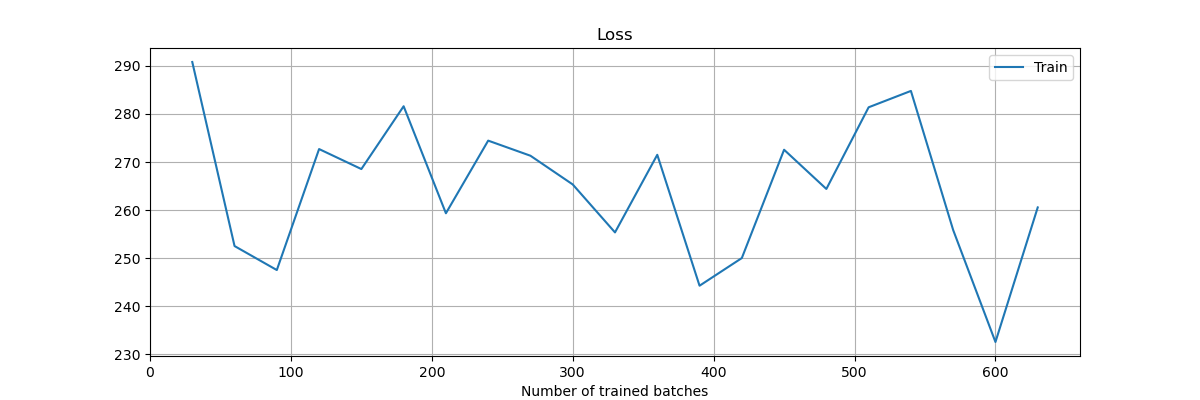

Epoch0 done
Epoch1 done
Epoch2 done


In [21]:
# Setup the figure for plotting progress during training
%matplotlib notebook
fig, ax = plt.subplots(ncols=1, figsize=(12,4))
plt.ion()
plot_interval = 30
batch_idxs = []
batch = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
losses = []
train_data = {'losses': []}

for epoch in range(3):
    for x, y in train_dataloader:
        b_x, b_y = x.to(device), y.to(device)
        pred = model(b_x)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        batch += 1

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % plot_interval == 0:
            train_data['losses'].append((sum(losses)/len(losses)))
            batch_idxs.append(batch)
            losses = []

            plot_metrics(fig, ax, batch_idxs, train_data['losses'])

    print(f"Epoch {epoch} done")


# Compute predictions in the validation set (with adagrad deactivated)
# losses = []
# n_correct = 0
# with torch.no_grad():
#     iter = 0
#     for b_x, b_y in val_dataloader:
#         pred = model(b_x)
#         loss = loss_fn(pred, b_y)
#         losses.append(loss.item())

#         iter += 1
#         if iter%10 == 0: 
#             print(f'{iter} batches validated')

#         if iter == 50: 
#             break

#         #hard_preds = pred.argmax(dim=1)
#         #n_correct += (pred.argmax(dim=1) == b_y).sum().item()
#     #val_accuracy = n_correct/len(test_dataset)
#     val_avg_loss = sum(losses)/len(losses)      
        
        
    

<IPython.core.display.Javascript object>


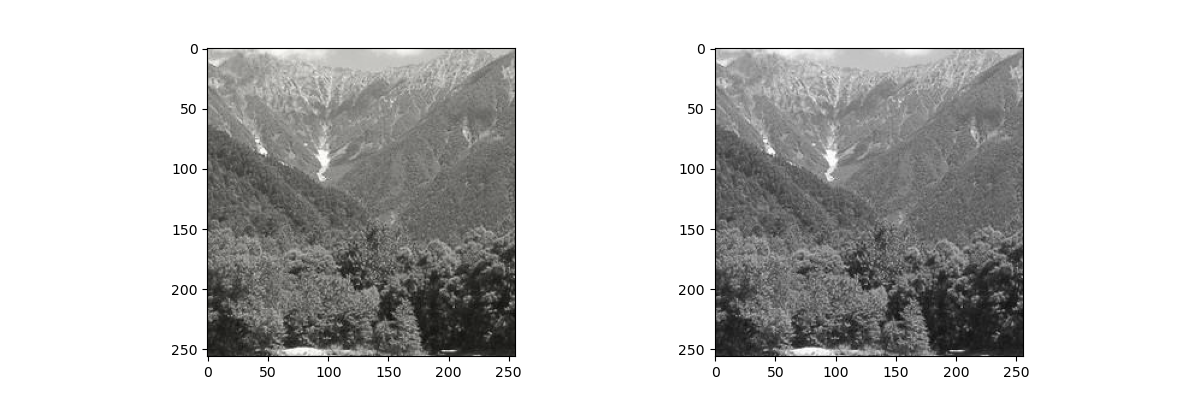

In [22]:
with torch.no_grad():
    l, ab = example_dataset[some_random_index]
    l_batch = torch.unsqueeze(l, 0)
    l_batch = l_batch.cuda()
    ab_res = model.forward(l_batch)
    ab_res = ab_res.cpu()
    ab_res = torch.squeeze(ab_res, dim = 0)
    plot_comb(l, ab_res)